In [24]:
import numpy as np
import torch
import pandas as pd

from matplotlib import pyplot as plt
from math import pi
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [81]:
class SineData(Dataset):
    """
    Dataset of functions f(x) = a * sin(b * x + c) where a and b are randomly
    sampled. The function is evaluated from -pi to pi.
    Parameters
    ----------
    amplitude_range : tuple of float
        Defines the range from which the amplitude (i.e. a) of the sine function
        is sampled.
    periodicity_range: tuple of float
        Defines the range from which the periodicity (i.e. b) of the sine function
        is sampled.
    shift_range : tuple of float
        Defines the range from which the shift (i.e. b) of the sine function is
        sampled.
    num_samples : int
        Number of samples of the function contained in dataset.
    num_points : int
        Number of points at which to evaluate f(x) for x in [-pi, pi].
    """

    def __init__(self, amplitude_range=(0.4, 1.6), periodicity_range=(1., pi + (pi - 1.0) * 0.5),
                 shift_range=(0, pi), num_samples=3000, num_points=100):
        self.amplitude_range = amplitude_range
        self.periodicity_range = periodicity_range
        self.shift_range = shift_range
        self.num_samples = num_samples
        self.num_points = num_points
        self.x_dim = 1  # x and y dim are fixed for this dataset.
        self.y_dim = 1

        # Generate data
        self.data = []
        a_min, a_max = amplitude_range
        b_min, b_max = periodicity_range
        c_min, c_max = shift_range
        for i in range(num_samples):
            # Sample random amplitude
            a = (a_max - a_min) * np.random.rand() + a_min

            # For VERSION 3
            # Sample random periodicity
            b = (b_max - b_min) * np.random.rand() + b_min
            # Sample random shift
            c = (c_max - c_min) * np.random.rand() + c_min
            # Shape (num_points, x_dim)
            x = torch.linspace(0, 9.9, num_points).unsqueeze(1)
            # Shape (num_points, y_dim)

            # For VERSION 1
            # y = a * torch.sin(x + c)

            # For VERSION 2
            # y = a * torch.sin(x * pi + c)

            # For VERSION3
            y = a * torch.sin(x * b + c)

            # For noisy version
            noise = torch.randn(y.shape) * 0.03
            y += noise

            traj_idx = torch.ones_like(x) * i

            self.data.append((traj_idx, x, y))

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.num_samples

In [82]:
data_val = SineData(num_samples=500)

In [83]:
import pickle

In [84]:
f = open('test_data.pickle', 'wb')
pickle.dump(data_val, f)
f.close()

In [85]:
f = open('val_data.pickle', 'rb')
obj = pickle.load(f)
f.close()

In [16]:
dataset = SineData(amplitude_range=(0.4, 1.6),
                   periodicity_range=(1., pi + (pi - 1.0) * 0.5),
                   shift_range=(0, pi),
                   num_samples=3000,
                   num_points=100)

In [22]:
len(dataset)

3000

In [27]:
dl = DataLoader(dataset, batch_size=32, shuffle=True)

In [48]:
test_dl = iter(dl).__next__()

In [49]:
test_dl[0].shape

torch.Size([32, 100, 1])

In [50]:
test_dl = torch.stack(test_dl, 2).squeeze()

In [55]:
test_dl[:, :, 2:].shape

torch.Size([32, 100, 1])

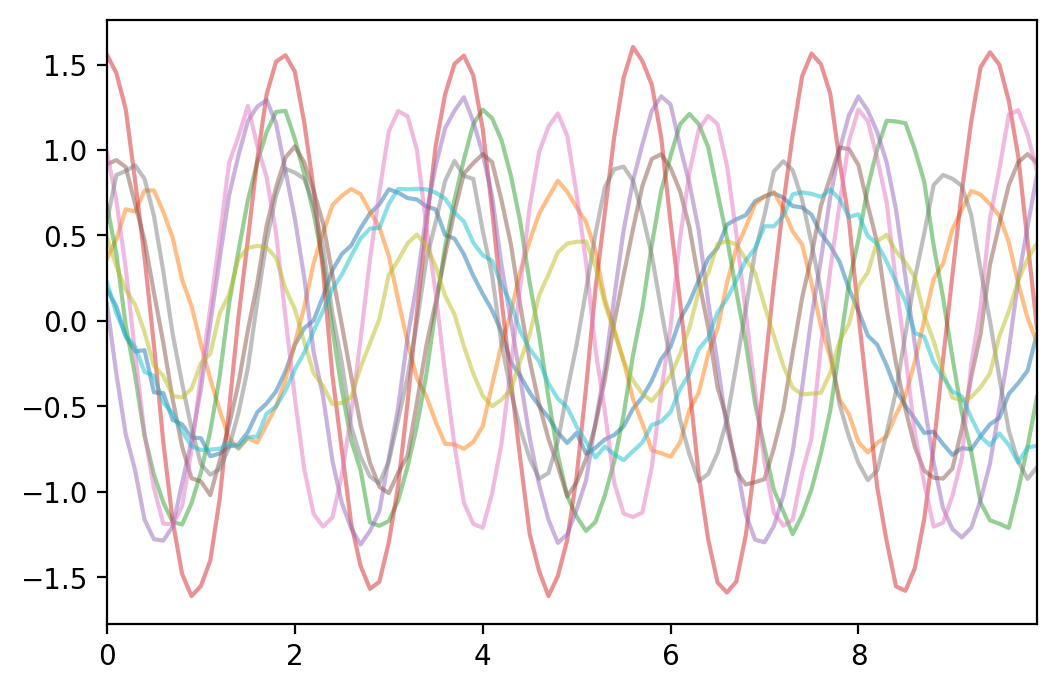

In [9]:
plt.figure(dpi=200)

for i in range(10):
    x, y = dataset[i]
    plt.plot(x.numpy(), y.numpy(), alpha=0.5)
    plt.xlim(0, 9.9)

plt.savefig('noisy_diverse_example.png')
plt.show()

In [57]:
sine_list = []
for i in range(3000):
    sine_list.append(dataset[i][1])

In [58]:
sine_tensor = torch.stack(sine_list)
sine_tensor = sine_tensor.squeeze()
sine_array = sine_tensor.numpy()

In [59]:
time_array = np.arange(0.0, 5.0, 0.1)
time_array = time_array.reshape(1, -1)
time_array = np.repeat(time_array, 3000, 0)

In [60]:
time_array.shape == sine_array.shape

True

In [61]:
sample_idx = np.arange(0, 3000, 1)
sample_idx = np.repeat(sample_idx, 50)

In [62]:
sine_df = pd.DataFrame({'sample_idx': sample_idx, 'time': time_array.reshape(-1), 'sine_val': sine_array.reshape(-1)})

In [63]:
sine_df.to_csv('sinusoid_noisy_div_3000.csv', index=False)

In [260]:
class decay_dataset(Dataset):
    def __init__(self, data_path, idx):
        self.all_data = pd.read_csv(data_path)
        
        self.all_data = self.all_data.loc[self.all_data['sample_idx'].isin(idx)].copy()
        unique_idx = self.all_data['sample_idx'].unique()
        map_dict = dict(zip(unique_idx, np.arange(len(unique_idx))))
        
        self.all_data['sample_idx'] = self.all_data['sample_idx'].map(map_dict)
        self.all_data.set_index('sample_idx', inplace=True)
        
        self.length = len(unique_idx)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        traj = self.all_data.loc[idx]
        
        return {"idx": idx, "traj": traj}

In [261]:
decay_dataset('./sinusoid.csv', np.arange(100))[0]

{'idx': 0,
 'traj':             time  sine_val
 sample_idx                
 0            0.0  0.761019
 0            0.1  0.736587
 0            0.2  0.704794
 0            0.3  0.665959
 0            0.4  0.620470
 0            0.5  0.568782
 0            0.6  0.511411
 0            0.7  0.448929
 0            0.8  0.381962
 0            0.9  0.311179
 0            1.0  0.237287
 0            1.1  0.161023
 0            1.2  0.083151
 0            1.3  0.004448
 0            1.4 -0.074299
 0            1.5 -0.152304
 0            1.6 -0.228788
 0            1.7 -0.302985
 0            1.8 -0.374155
 0            1.9 -0.441587
 0            2.0 -0.504606
 0            2.1 -0.562584
 0            2.2 -0.614940
 0            2.3 -0.661152
 0            2.4 -0.700758
 0            2.5 -0.733363
 0            2.6 -0.758640
 0            2.7 -0.776337
 0            2.8 -0.786276
 0            2.9 -0.788360
 0            3.0 -0.782567
 0            3.1 -0.768954
 0            3.2 -0.747658
 

In [262]:
def sinusoid_collate(batch):
    t = torch.tensor(batch[0]["traj"]["time"].values)
    traj_columns = [False, True]
    trajs = [torch.from_numpy(b["traj"].iloc[:, traj_columns].values) for b in batch]
    trajs = torch.stack(trajs, dim=0)

    res = dict()
    res["time"] = t
    res["traj"] = trajs
    return res

In [263]:
data_temp = decay_dataset('./sinusoid.csv', np.arange(100))

In [158]:
from torch.utils.data import DataLoader

In [160]:
dl_train = DataLoader(dataset=data_temp, shuffle=True, collate_fn=sinusoid_collate,
                      batch_size=32)

In [166]:
A = iter(dl_train).__next__()

In [171]:
A['time'].shape

torch.Size([50])

In [170]:
A['traj'].shape

torch.Size([32, 50, 1])

In [103]:
context_idx = np.random.choice(np.arange(10, 20), 3, replace=False)

In [117]:
context_idx.sort()

In [118]:
context_idx

array([13, 18, 19])

In [111]:
target_idx = np.random.choice(np.arange(0, 10), 3, replace=False)

In [115]:
np.concatenate([context_idx, target_idx])

array([19, 18, 13,  9,  7,  6])

In [108]:
test_dl[:, context_idx, :].shape

torch.Size([32, 3, 3])